# Модели

Для построения модели, стилистически отражающей поэзию определенного автора пятерки, необходимо ориентироваться больше на семантику, чем на лингвистические требования, так как ритм, слоган и рифмы в целом у всех авторов (кроме для Маяковского, сильно выделенного метром). Поэтому важно уделять больше внимания тому, какие именно слова подобраны, каковы интонации и поэтический строй. В этом напрямую поможет дополнительное обучение модели на сформированном ранее корпусе текстов. Такой подход называется файнтюнингом, так как мы не учим  огромную модель GPT-3 заново (по крайней мере, ресурсов для этого просто не хватает), что сложно и долго, а пытаемся расширить текущее представление (веса параметров) модели и акцентируем ее внимание на определенном типе текстов, которые мы ей даем, чтобы модель соответствовала поставленной задаче.

А затем, после того как мы сфокусировали модель на определенном типе текста, мы можем генерировать текст, используя методы генерации, которые можно заметить ниже.

Здесь можно найти ссылку на колабы со всеми моделями для 5 авторов:

* [Маяковский](https://colab.research.google.com/drive/18Jjs--iKbt938er-IbQ4SPXKY50-txpH?usp=sharing)
* [Тютчев](https://colab.research.google.com/drive/13xnmaOfmEk_DvUDSE5Ok6Pmf9cTlmHJl?usp=sharing)
* [Блок](https://colab.research.google.com/drive/17fIyK7aE329M7pIgsZztT7f6SHIZT5JG?usp=sharing)
* [Есенин](https://colab.research.google.com/drive/1flLH907PWBdibBi0jkz-eFKynppxHZBl?usp=sharing)
* [Пушкин](https://colab.research.google.com/drive/1iyrM72phmNC9YBB0Ipw13xJBGO-DWYsU?usp=sharing)


Чтобы понять, что там происходит и как мы файнтюнили средний ruGPT-3, основанный на GPT-2 (потому что больше наши вычислительные мощности не тянут), можно возпользоваться нашими статьями, в которых используется такая же технология, только для генерации новостей:

1. Все про добучение, GPT-3 и [как сделать генератора новостей самому](https://habr.com/ru/post/719874/)
2. Все про то, как генерирововать текст с помощью наших моделек с Hugging Face [статья](https://habr.com/ru/post/717292/)

##Описание того, как мы тюнили

Для каждого автора непосредственно обучалась своя модель, так что для каждого из них своя стиль был построен внутри моделей. Использовались разные параметры, но в среднем количество эпох для каждого автора не превышало 80, размер входного пакета было 4,8,16, а количество шагов накопления градиента = 1, что делало можно уделить больше внимания каждому отдельному набору слов.

Интересная тенденция, которая помогла для почти всех моделей сильно повысить качество генерации, это то, что сначала мы тюнили модели, задавая большое количество эпох, но малое количество warmup_steps( параметр, отвечающий за количество начальных шагов обучения, в течение которых скорость обучения постепенно увеличивается от меньшего значения до максимальной скорости обучения ). А затем мы тюнили небольшое количество эпох на тех же самых данных с большим значением этого параметра, равным 100-150. 

**Почему так?** 
При отсутствии изменений в параметре warmup_steps и увеличении эпох модель быстро переобучалась, а при изменении этого параметра и не изменении количества эпох плохо и долго училась.

### Очистка и предобработка

**шаг 1:** удалить из датасета по [ссылке](https://github.com/sberbank-ai/classic-ai/blob/master/data/classic_poems.json) все лишнее, кроме автора и списка, где по строкам лежали происзведения

**шаг 2**: провести глобальную очистку на символы, которые не должны появляться в тексте (датасет был очень грязный, потому что взят и соревнования), а еще на иностранные языки, потому что любовь Пушкина писать на французском ломала дообучение максимально

**шаг 3**: распилить на небольшие кусочки, потому что ни одна модель за раз не сможет проглотить и проанализировать целого Евгения Онегина. Методом анализа было выяснено, что лучший разрез будет по 12 строк - таким образом мы захватим в небольшом куске текста все виды рифм, характерные для поэтов. А еще здесь было обнаружено, что поэты сами очень любят комментировать свои стихи и часто встречались абзацы нерифмованного текста, который так же мешал обучению. 

не говоря уже о том, что поэты очень любили писать стихи без рифм, а строчки, в которых проглядывался в лучшем случае ритм, а по-хорошему это был построчный текст. 

Но супертщательная очистка была проведена, текст был распилен и готов к дообучению.

## Импорты

In [ ]:
import pandas as pd

In [ ]:
!pip install transformers==4.19.0

/bin/bash: /root/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import StoppingCriteria, StoppingCriteriaList
import torch

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else None

In [ ]:
!pip install openpyxl

/bin/bash: /root/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Интерфейс для генерации текста

В конце этого блока можно запустить функцию для получения интерфейса с открытой ссылкой, которой можно делиться и в течении 72 часов генерировать стихи в свое удовольствие

In [ ]:
class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords_ids:list):
      self.keywords = keywords_ids

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
      if input_ids[0][-1] in self.keywords:
        print(input_ids)
        return True
      return False

Скачиваем все модели, токенайзер (который один для всех моделей от сбера), добавляем в токенайзер специальные символы и прописываем критерий остановки на то, чтобы когда мы видели токен конца предложения - останавливать генерацию

In [ ]:
model_mayak = GPT2LMHeadModel.from_pretrained('AnyaSchen/rugpt3_mayakovskij').to(DEVICE)
model_blok = GPT2LMHeadModel.from_pretrained('AnyaSchen/rugpt3_blok').to(DEVICE)
model_esenin = GPT2LMHeadModel.from_pretrained( 'AnyaSchen/rugpt3_esenin').to(DEVICE)
model_pushkin = GPT2LMHeadModel.from_pretrained('AnyaSchen/rugpt3_pushkin').to(DEVICE)
model_tyutchev = GPT2LMHeadModel.from_pretrained('AnyaSchen/rugpt3_tyutchev').to(DEVICE)
tokenizer = GPT2Tokenizer.from_pretrained('sberbank-ai/rugpt3medium_based_on_gpt2')
SPECIAL_TOKENS = {'bos_token':'<bos>','eos_token' :'<eos>', 'pad_token':'<pad>', 'sep_token': '<sep>'}
tokenizer.add_special_tokens(SPECIAL_TOKENS)

stop_criteria = KeywordsStoppingCriteria(tokenizer.encode(tokenizer.eos_token, return_tensors="pt").to(DEVICE))

In [ ]:
def get_model_from_poet(poet: str):
  poet2model = {
    'Маяковский': model_mayak,
    'Пушкин': model_pushkin,
    'Есенин': model_esenin,
    'Блок': model_blok,
    'Тютчев': model_tyutchev
  }

  return poet2model[poet]

In [ ]:
def generate_poetry(input: str, model, num_beams=3):
  input = input if len(input) > 0 else tokenizer.bos_token #токен начала предложения
  input_ids = tokenizer.encode(input, return_tensors="pt").to(DEVICE)

  with torch.no_grad():
        out = model.generate(input_ids,
                            do_sample=True,
                            num_beams=num_beams,
                            temperature=2.0,
                            top_p=0.9,
                            max_length = 200,
                            stopping_criteria=StoppingCriteriaList([stop_criteria]),
                            eos_token_id=tokenizer.eos_token_id,
                            bos_token_id=tokenizer.bos_token_id,
                            ).to(DEVICE)
  return tokenizer.batch_decode(out, skip_special_tokens=True)[0]

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def greet(input: str, poet: str, num_beams : int):
  model = get_model_from_poet(poet)
  return generate_poetry(input, model, num_beams)
  

demo = gr.Interface(fn=greet,
                    inputs=["text", gr.Radio(['Маяковский', 'Пушкин', 'Есенин', 'Тютчев', 'Блок']), gr.Slider(3, 6)],
                    outputs="text")

demo.launch(share=True, debug=True) 

# Данные поэзии и ембеддингов

Для того, чтобы оценить, на сколько хорошо наши обученные модели умеют генерировать стихи в стилистике определенных авторов нам необходимо нагенерировать датасет стихов и, например, с помощью BERTа получить эмбеддинги токенов и сравнить их.

То, как мы генерировали поэзию и получали эмбеддинги с помощью модели BERT можно посмотреть [тут](https://colab.research.google.com/drive/1hG8EpGyyO4wUhBahtU-JH22kOmsPA7wx?usp=sharing)

In [ ]:
dir_path = './poetry_generation'

In [ ]:
# !wget https://www.dropbox.com/s/b6q4tokw0skjsfz/real_poetry.pkl?dl=0 -O real_poetry.pkl
# !wget https://www.dropbox.com/s/woyuwz0qkqt8oly/generated_poetry.pkl?dl=0 -O generated_poetry.pkl
# !wget https://www.dropbox.com/s/m7ts7003wqcwnci/embedding_real_generated.pkl?dl=0 -O embedding_real_generated.pkl

In [ ]:
import pickle

import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def load_embeddings():
  file_name = '/embedding_real_generated.pkl'

  with open(dir_path + file_name, 'rb') as f:
    embeddings_dict = pickle.load(f)

  return embeddings_dict

In [ ]:
embeddings_dict = load_embeddings()

In [ ]:
POETS = list(embeddings_dict.keys())

In [ ]:
def load_poetry():
  with open(dir_path + '/real_poetry.pkl', 'rb') as f:
      real_poetry_dataset = pickle.load(f)
  with open(dir_path + '/generated_poetry.pkl', 'rb') as f:
      generated_poetry_dataset = pickle.load(f)

  poetry_dict = {poet: {} for poet in POETS}
  
  for poet in POETS:
    poetry_dict[poet]['real'] = real_poetry_dataset[poet]
    poetry_dict[poet]['generated'] = generated_poetry_dataset[poet]
  return poetry_dict

In [ ]:
poetry_dict = load_poetry()

# Перплексия

Перплексия используется во время обучения как лосс-функция, но теперь мы посмотрим, какая она в среднем будет для сгенерированных и реальных текстов

In [ ]:
poet_eng2model = {
    'mayakovskij': model_mayak,
    'pushkin': model_pushkin,
    'esenin': model_esenin,
    'blok': model_blok,
    'tyutchev': model_tyutchev
  }

In [ ]:
import torch
from torch.nn.functional import cross_entropy

def compute_perplexity(texts, model, tokenizer = tokenizer):
    total_loss = 0.0
    total_tokens = 0

    # Set the device based on the availability of GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the model to the appropriate device
    model.to(device)

    for text in texts:
        tokens = tokenizer(text, return_tensors="pt")
        input_ids = tokens["input_ids"].to(device)  # Move the input_ids to the appropriate device

        with torch.no_grad():
            outputs = model(input_ids)
        logits = outputs["logits"]

        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()
        
        loss = cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1), reduction="sum")
        total_loss += loss.item()
        total_tokens += input_ids.numel() - 1  # Exclude the last token

    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

In [ ]:
perplexity_dict = {poet: {} for poet in POETS}

for poet, poetry in poetry_dict.items():
  print(poet)
  real_poetry = poetry['real']
  generated_poetry = poetry['generated']

  perplexity_dict[poet]['real'] = compute_perplexity(real_poetry, poet_eng2model[poet])
  perplexity_dict[poet]['generated'] = compute_perplexity(generated_poetry, poet_eng2model[poet])

pushkin
esenin
blok
tyutchev
mayakovskij


In [ ]:
import pandas as pd

# Convert the nested dictionary to a list of dictionaries
data = [{'poet': poet, 'type': t, 'perplexity': perplexity} for poet, values in perplexity_dict.items() for t, perplexity in values.items()]

# Create a pandas DataFrame
df = pd.DataFrame(data)

df

,poet,type,perplexity
0,pushkin,real,2.464533
1,pushkin,generated,3.959542
2,esenin,real,1.413197
3,esenin,generated,3.136536
4,blok,real,2.353163
5,blok,generated,3.776752
6,tyutchev,real,1.283463
7,tyutchev,generated,2.791120
8,mayakovskij,real,1.903071
9,mayakovskij,generated,2.738557


**Вывод:** Логично предположить, что наша модель будет показывать меньшую перплексити на реальных данных, на которых она файнтюнилась, чем на сгенерированных. При этом, для сгенерированных данных можно заметить, что перплексия варьируется от 2-4 примерно, что показывает, что у модели сохранилось разнообразие и она выбирает между 2-4 словами на следующем шаге генерации, а не знает только одно слово, которое должно идти следом (т.е. не запоминает готовые последовательности, а учится обощать)

# Оценка качества ембеддингов

## Косинусная близость

Подсчитывая среднюю косинусную близость эмбеддингов можно понять на сколько близко представление слов, которое мы сформировали у модели, с реальными творениями. 

А еще вспомним, что мы использовали для обучения **совсем небольшую модель**, потому что большая версия превышала возможности виртуалки для тюнинга. 

Небольшая модель плоха потому, что у нее мало параметров, то есть меньше возможностей посмотреть на данные под разными углами (с разными attentions), поэтому она достаточно быстро переобучалась, т.е. запоминала готовые последовательности и писала копиями строк.


In [ ]:
def avg_cosine_similarity(embeddings1, embeddings2):
    total_similarity = 0
    for emb1 in embeddings1:
        similarities = [1 - cosine(emb1, emb2) for emb2 in embeddings2]
        total_similarity += max(similarities)
    return total_similarity / len(embeddings1)

for poet in POETS:
  similarity = avg_cosine_similarity(embeddings_dict[poet]['generated'], embeddings_dict[poet]['real'])
  print(f"Average cosine similarity for {poet}: {similarity:.4f}")

Average cosine similarity for pushkin: 0.7176
Average cosine similarity for esenin: 0.7134
Average cosine similarity for blok: 0.7228
Average cosine similarity for tyutchev: 0.7109
Average cosine similarity for mayakovskij: 0.7889


Но даже тот результат, который у нас получился - хорош:
1. Схожесть сгенерированного нами Пушкина и реального около 72%, скорее всего большая схожесть привела бы к переобучению
2. аналогично и у остальных моделей, но Маяковский показывает себя лучше всего. Это может быть потому что в его стилистике написания поэзии прослеживается четкий и характерный подход (например, его любимые отступы), которую модели уловить легко. В то время остальные поэты часто экспериментировали с подходом написания, что путало модель и не позволяло ей находить отличительные характерные черты поэзии.

## Распределение косинусных близостей

Вычисляем максимальное косинусное сходство между каждым сгенерированным стихотворением и всеми реальными стихотворениями для каждого поэта, а затем строим гистограмму этих максимальных сходств, чтобы визуализировать распределение сходств.

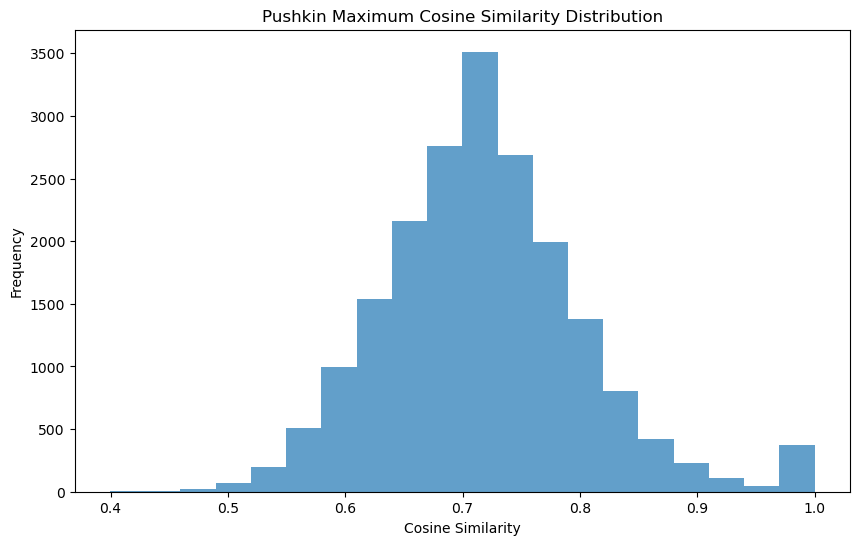

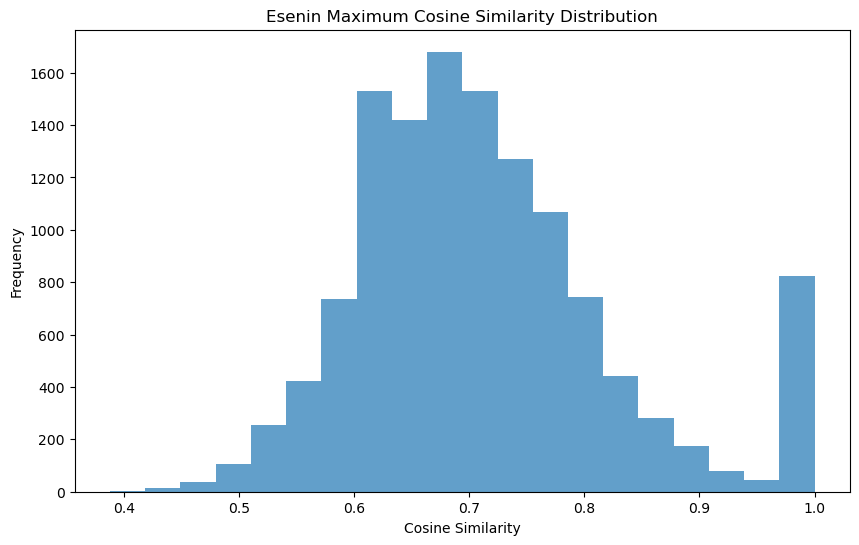

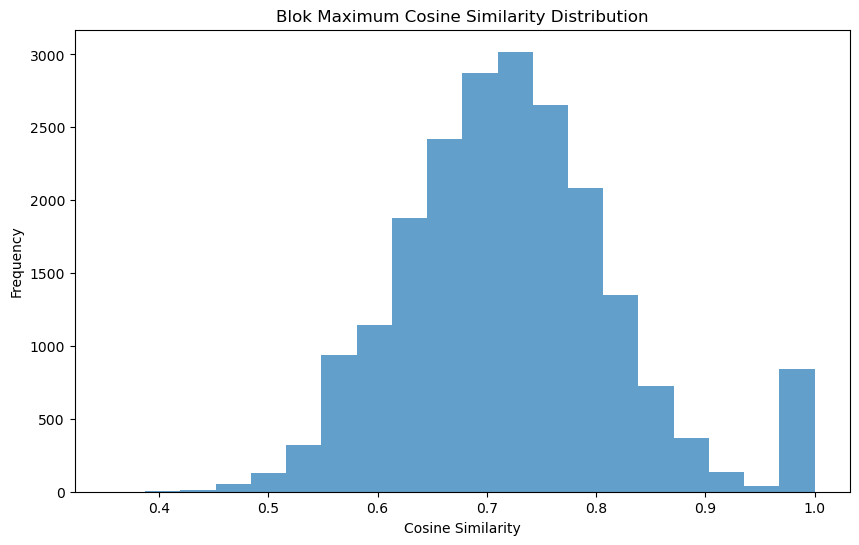

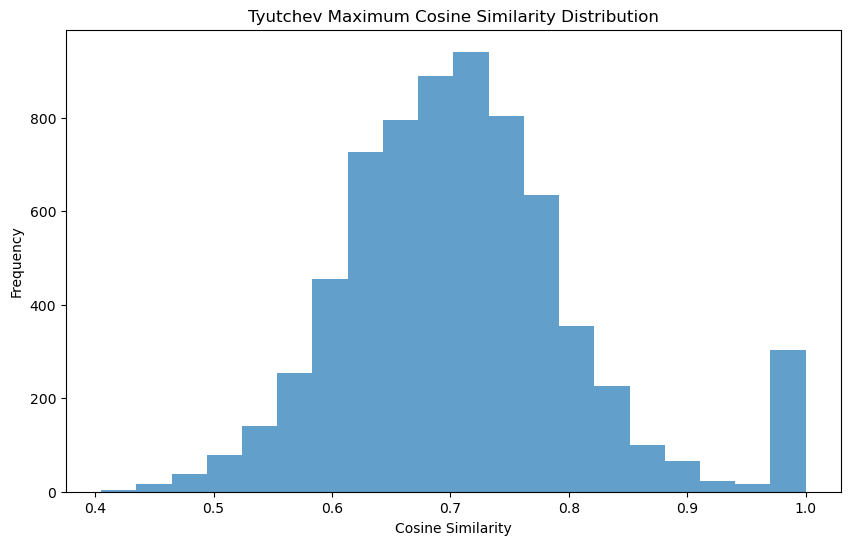

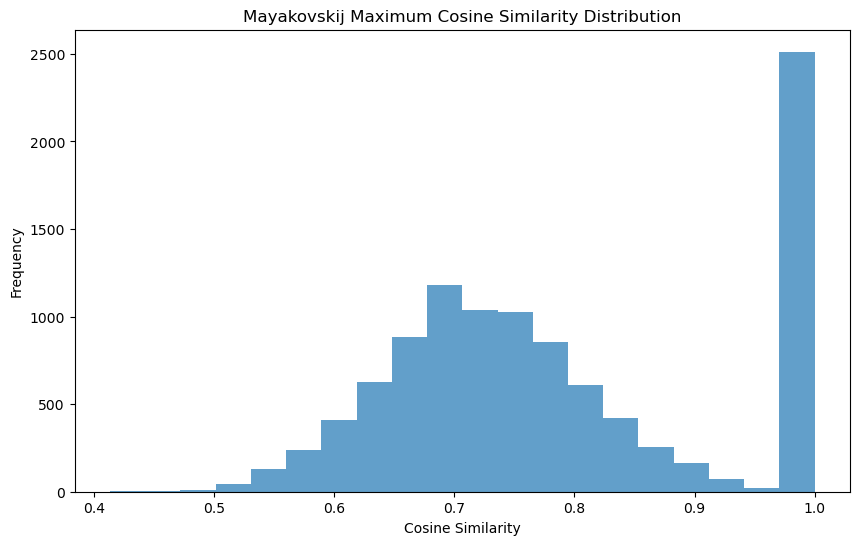

In [ ]:
for poet, embeddings in embeddings_dict.items():
    real_embeddings = embeddings['real']
    generated_embeddings = embeddings['generated']

    # Compute pairwise cosine similarity
    similarity_matrix = 1 - cdist(real_embeddings, generated_embeddings, metric='cosine')

    # Get the maximum similarity for each generated poem
    max_similarities = np.max(similarity_matrix, axis=0)

    # Plot histogram
    plt.figure(figsize=(10,6))
    plt.hist(max_similarities, bins=20, alpha=0.7)
    plt.title(f'{poet.capitalize()} Maximum Cosine Similarity Distribution')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.show()

**Выводы:** 
1. Среднее этого не показало, но у Маяковского большая часть косинусных близостей в матрице близка к 1, а значит модель наиболее вероятно выдаст поэзию на 100% похожую на стихи Маяковского.
2. Заметим, что у Есенина, Блока и Тютчева так же есть средняя вероятность получить 100% сходство с оригиналом, но большинство данных генерируются со сходством в 65-75%.
3. Пушкин очень близок к нормальному распределению и наиболее вероятно модель будет генерировать 70% точности.

Данные оценки говорят о том, что несмотря на небольшой размер, модели удалось поймать стилистику поэтов на 70% и больше. Будь у нас модель по-больше - результаты бы получились еще лучше, но и это уже очяень хорошо!

## t-SNE


# Новый раздел

Внедрение t-распределенных стохастических соседей (t-SNE) — популярный метод уменьшения размерности и визуализации многомерных данных. Мы использовали t-SNE, чтобы спроецировать эмбеддинги на двумерную плоскость и визуализировать, как сгенерированная и реальная поэзия группируются вместе для каждого поэта.

/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


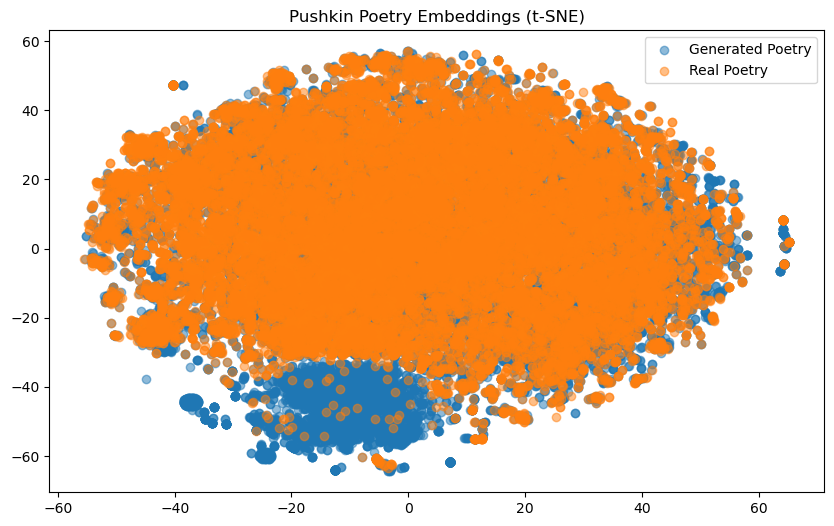

/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


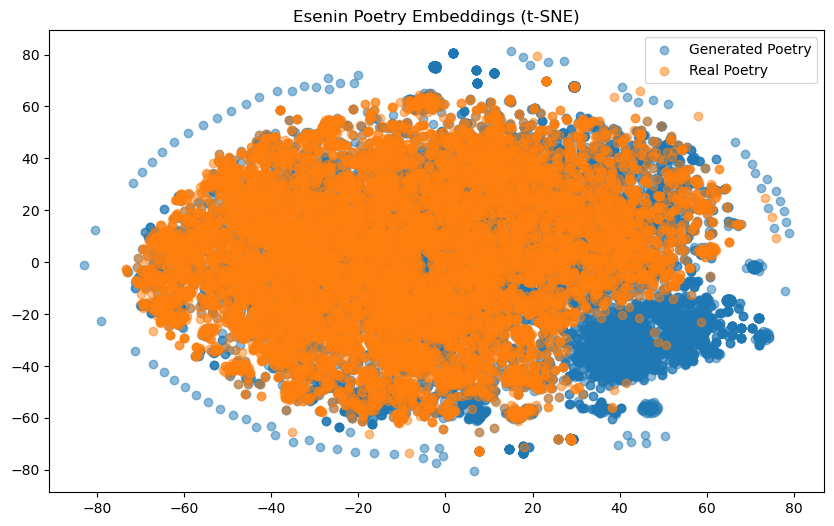

/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


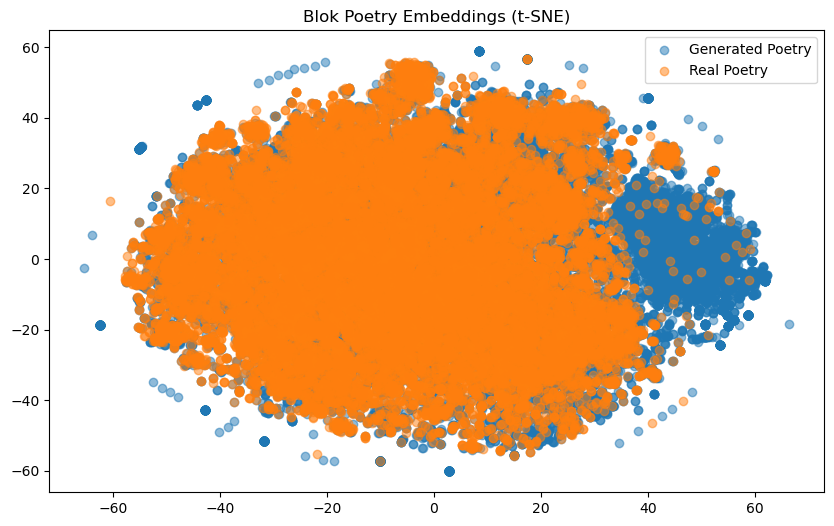

/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


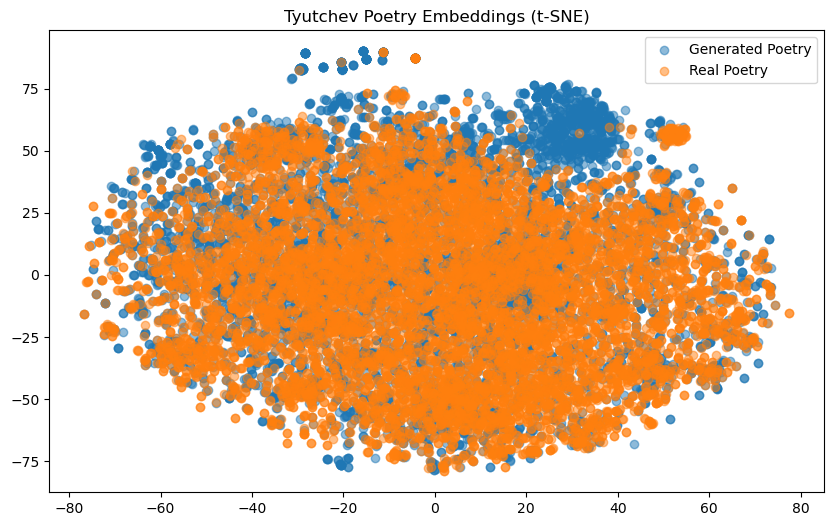

/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


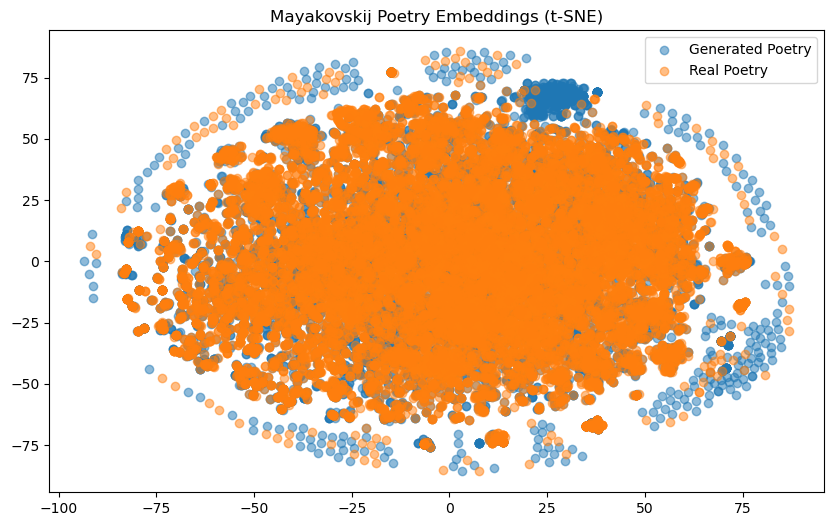

In [ ]:
np.random.seed(42)

for poet, embeddings in embeddings_dict.items():
    real_embeddings = embeddings['real']
    generated_embeddings = embeddings['generated']

    # Combine real and generated embeddings
    combined_embeddings = np.vstack((real_embeddings, generated_embeddings))

    # Perform t-SNE dimensionality reduction
    tsne_embeddings = TSNE(n_components=2).fit_transform(combined_embeddings)

    # Separate real and generated embeddings after t-SNE transformation
    real_tsne_embeddings = tsne_embeddings[:len(real_embeddings)]
    generated_tsne_embeddings = tsne_embeddings[len(real_embeddings):]

    # Plot t-SNE embeddings
    plt.figure(figsize=(10,6))
    plt.scatter(generated_tsne_embeddings[:, 0], generated_tsne_embeddings[:, 1], label='Generated Poetry', alpha=0.5)
    plt.scatter(real_tsne_embeddings[:, 0], real_tsne_embeddings[:, 1], label='Real Poetry', alpha=0.5)
    plt.title(f'{poet.capitalize()} Poetry Embeddings (t-SNE)')
    plt.legend()
    plt.show()

**Выводы:** теперь можно конкретно увидеть, где мы теряем 20-30% сходства
1. Интересно, что практически у любого поэта мы видим, что эмбеддинги сгенерированной поэзии стремятся к плотному обобщению, в то время как реальная поэзия, возможно, специально органичивается и избегает каких-то близких приемов. Поэтому появляются синие концентрированные пятна.
2. При этом реальная поэзия полностью перекрывается сгенерированной, что говорит о том, что наша модель "смотрит чуть шире" и из-за этого теряет в сходстве по стилистике
3. Можно заметить у Маяковского, что часть эмбеддингов (и реальных, и сгенерированных) находятся за гранью кластера, что показывает стремление автора "выходить за рамки" 

# Latent Dirichlet Allocation (LDA)

Чтобы понять, на сколько действительно модели смогли уловить общую тематику поэзии разных творцов, мы решили воспользоваться LDA.

In [ ]:
!pip install nltk

/bin/bash: /root/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!pip install stop_words

/bin/bash: /root/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... - done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32893 sha256=6c209c693e2df8ba98e6ca019a1e0a89a8dc66609cfb44c7be80d00645ca770b
  Stored in directory: /root/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
Successfully built stop_words


In [ ]:
import nltk
import re
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('punkt')

# Download the NLTK Russian stopwords
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words("russian")
stop_words.extend(get_stop_words("ru"))

# Preprocess the text
def preprocess_text(text):
    text = re.sub(r"[^а-яА-Яё\s]", "", text)  # Remove all symbols except Cyrillic lowercase letters [а-я]
    words = nltk.word_tokenize(text.lower())  # Tokenize and lowercase
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

def display_topics(lda, feature_names, n_top_words):
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print("\n")

# Parameters for LDA
n_topics = 1
n_top_words = 10

for poet, categories in poetry_dict.items():
    print(f"Poet: {poet.capitalize()}")
    
    for category, poems in categories.items():
        print(f"Category: {category.capitalize()}")

        # Preprocess texts
        preprocessed_texts = [preprocess_text(text) for text in poems]

        # Create a document-term matrix
        vectorizer = CountVectorizer()
        doc_term_matrix = vectorizer
        doc_term_matrix = vectorizer.fit_transform(preprocessed_texts)

        # Apply the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(doc_term_matrix)

        # Display the top words for each topic
        feature_names = vectorizer.get_feature_names_out()
        print("Topics:")
        display_topics(lda, feature_names, n_top_words)

    print("=" * 40)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Poet: Pushkin
Category: Real
Topics:
Topic #1:
друг любви ль иль моей пред свой вновь милый любовь


Category: Generated
Topics:
Topic #1:
друг ль любви моей милый ах скажи люблю слезы вновь


Poet: Esenin
Category: Real
Topics:
Topic #1:
сердце знаю ль словно пусть глаза свет ой русь тихо


Category: Generated
Topics:
Topic #1:
глаза знаю сердце вижу ах друг жизни поэт старик ль


Poet: Blok
Category: Real
Topics:
Topic #1:
ночь сердце ветер душа ночи свет час моей сон голос


Category: Generated
Topics:
Topic #1:
ночь ветер сердце жизни глаза друг руки смотри тихо свет


Poet: Tyutchev
Category: Real
Topics:
Topic #1:
мир сей свой ль иль свет сердце пред жизни души


Category: Generated
Topics:
Topic #1:
мир свой сердце сей любви любовь дух сон недаром час


Poet: Mayakovskij
Category: Real
Topics:
Topic #1:
глаза солнце рот ст клим рабочий дело пусть ль глаз


Category: Generated
Topics:
Topic #1:
ст солнце здравствует эй глаза пусть знает мир слава рабочие




**Вывод:**
Общие тематики модели действительно поймали хорошо, поскольку как для сгенерированных, так и для реальных данных, наборы ключевых слов для формирования темы идентичны.
Значит, наши модели хорошо поймали основную тенденцию стилистики и тематик поэтов и заметим, что они разные:

1. Пушкин - это про любовь
2. есенин - это человек в природе
3. Блок - ночь, ветер, свет
4. Тютчев - душа, сердце
5. Маяковский - это про работу и бравое дело